# Derive terrain attributes from a Digital Elevation Model (DEM)

## Description
The purpose of this notebook is to compute terrain attributes from a Digital Elevation Model (DEM) for a specific area of interest. These terrain attributes provide important information about the topographic characteristics of the landscape and are particularly useful for studying wetlands. The notebook calculates various terrain indices such as aspect, curvature, Topographic Wetness Index (TWI), Terrain Profile Index (TPI), and Depth-to-Water. These indices offer insights into slope, orientation, shape, hydrology, water flow patterns, and other factors relevant to wetlands. By deriving these terrain attributes, researchers and analysts can better understand wetland dynamics, assess habitats, model ecosystems, and plan conservation strategies. The resulting terrain indices enhance wetland mapping, classification, and analysis, facilitating more accurate and detailed studies related to wetland ecosystems.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Inastall and load packages" cell.

## Install and load Packages

### Optional - Install onetime

In [1]:
%matplotlib inline

import os
import requests
import time

import rasterio
import rioxarray

import numpy as np
import xarray as xr
import xarray as xr
import richdem as rd
import geopandas as gpd
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry
import odc.stac
import planetary_computer
import pystac_client
from datacube.utils.cog import write_cog
from scipy.ndimage import label, distance_transform_edt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import display_map


import warnings
warnings.filterwarnings("ignore")

In [2]:
# For now, try this projection
CRS = 6933
# buffer value needed for mrvbf & mrrtf
# according to https://github.com/digitalearthafrica/dem-derivative/blob/main/tiled_dem_processing_saga.sh
BUFFER_M = 2430

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 24,Total memory: 43.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38393,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36045,Total threads: 24
Dashboard: http://127.0.0.1:36735/status,Memory: 43.97 GiB
Nanny: tcp://127.0.0.1:36477,


### Load vector and plot area of interest

In [4]:
def load_huc_boundary(huc_id) -> gpd.GeoDataFrame:
    url = "https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4/query"
    params = {
        "where": f"HUC8='{huc_id}'",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "geojson",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()


SKYKOMISH_HUC8_ID = "17110009"
aoi = load_huc_boundary(SKYKOMISH_HUC8_ID)
# Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(x=lon_range, y=lat_range)

### Derive terrain attributes

In [5]:
from pathlib import Path

# Define the output directory
output_dir = Path("/data/terrain_attributes/")
print(output_dir)
# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

/data/terrain_attributes


### Download and save DEM

In [6]:
def download_dem(aoi, output_file, **kwargs):
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    items = list(
        catalog.search(
            collections="3dep-seamless",
            bbox=aoi.total_bounds,
            query={"gsd": {"eq": 10}},
        ).items()
    )

    if not Path(output_file).exists():
        return (
            odc.stac.load(items, chunks=dict(x=8192, y=8192), **kwargs)
            .mean(dim="time")
            .squeeze(drop=True)
            .map(lambda da: da.rio.clip(aoi.to_crs(da.rio.crs).geometry))
            .data.rio.to_raster(output_file, driver="COG", overwrite=True)
        )


dem_file = output_dir / "dem.tif"
download_dem(
    geopolygon_gdf.to_crs(CRS).buffer(BUFFER_M).to_crs(4326),
    dem_file,
    crs=CRS,
    resolution=10,
)

In [7]:
# Either use the above to download a dem or load one you already have
# dem_file = "../../../data/processed/17110009_Skykomish_HE_DEM_3m.tif"
dem = rioxarray.open_rasterio(dem_file, chunks=True).squeeze(drop=True)
# Reset CRS if loading something else, in case it's different
CRS = dem.odc.crs

##### Fill DEM and export elevation to GeoTiff
The fill_depressions function aims to fill depressions (low points or sinks) in a Digital Elevation Model (DEM). The function iteratively raises the elevation of low points (depressions) in the DEM by setting them to the minimum value encountered so far, until no more depressions are detected. This process ensures that all local minima (sinks) are filled, resulting in a filled DEM where water would flow off instead of accumulating in depressions.

In [8]:
# Extract elevation data from the loaded dataset


def fill_depressions(dem):
    # Perform depression filling using some morphological operations.
    filled_dem = dem.copy()
    while True:
        marker = filled_dem.min()
        filled_dem = np.maximum(dem, marker)
        labels, num_features = label(dem > filled_dem)
        if num_features == 0:
            break
        dem = np.maximum(dem, filled_dem)
    return filled_dem


elevation_path = os.path.join(output_dir, "Elevation.tif")
filled_dem = fill_depressions(dem).compute().assign_attrs({"crs": CRS})
# Save elevation to GeoTiff
write_cog(filled_dem, fname=elevation_path, overwrite=True)

PosixPath('/data/terrain_attributes/Elevation.tif')

In [9]:
# chunk filled dem so operations can use dask
filled_dem = filled_dem.astype("float32").chunk(dict(x=3000, y=3000))

##### Export DEM SRTM Derivatives - MrRTF and MrVBF
**Multi-resolution Valley Bottom Flatness (MrVBF)** identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.

**Multi-resolution Ridge Top Flatness (MrRTF)** is complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.

In [10]:
from subprocess import run

def compute_derivatives(
    dem_path: Path, output_mrvbf_path: Path, output_mrrtf_path: Path, epsg: str | int
):
    shell_script = "create_mrvbf_mrrtf.sh"
    run([
        "bash",
        shell_script,
        str(dem_path),
        str(output_mrvbf_path),
        str(output_mrrtf_path),
        str(epsg),
    ])


def compute_slope(dem_path: Path, output_slope):
    run([
        "bash",
        "create_slope.sh",
        str(dem_path),
        str(output_slope),
    ])


mrvbf_path = output_dir / "mrvbf.tif"
mrrtf_path = output_dir / "mrrtf.tif"
# saga doesn't accept a full WKT string I don't think,
# so there will be an error if for complex CRSES. It's ok
# (well it should be fixed) since we can set it when we load
compute_derivatives(Path(elevation_path), mrvbf_path, mrrtf_path, str(CRS))

percent_slope_path = output_dir / "percent_slope.tif"
compute_slope(Path(elevation_path), percent_slope_path)

____________________________

   #####   ##   #####    ##
  ###     ###  ##       ###
   ###   # ## ##  #### # ##
    ### ##### ##    # #####
 ##### #   ##  ##### #   ##
____________________________

SAGA Version: 9.3.1

____________________________
library path: /usr/lib/x86_64-linux-gnu/saga/
library path: /usr/lib/x86_64-linux-gnu/saga/
library name: libio_gdal
library     : io_gdal
tool        : Import Raster
identifier  : 0
author      : O.Conrad (c) 2007 (A.Ringeler)
processors  : 24 [24]
____________________________

[Import Raster] Execution started...

__________
[Import Raster] Parameters:

Grids: No objects
Files: "/data/terrain_attributes/Elevation.tif"
Multiple Bands Output: automatic
Subsets: 
Select from Multiple Bands: 
Transformation: true
Resampling: Nearest Neighbour
Extent: original




Dataset: /data/terrain_attributes/Elevation.tif

Driver: GTiff

Bands: 1

Rows: 9825

Columns: 5001


loading: Elevation

100%
__________
total execution time: 0 milliseconds (less t

Unexpected option : /

Usage: gdal_edit [--help] [--help-general] [-ro] [-a_srs <srs_def>]
                 [-a_ullr <ulx> <uly> <lrx> <lry>] [-a_ulurll <ulx> <uly> <urx> <ury> <llx> <lly>]
                 [-tr <xres> <yres>] [-unsetgt] [-unsetrpc] [-a_nodata <value>] [-unsetnodata]
                 [-offset <value>] [-scale <value>] [-units <value>]
                 [-colorinterp_<X> {red|green|blue|alpha|gray|undefined]]...
                 [-unsetstats] [-stats] [-approx_stats]
                 [-setstats <min> <max> <mean> <stddev>]
                 [-gcp <pixel> <line> <easting> <northing> [<elevation>]]...
                 [-unsetmd] [-oo <NAME>=<VALUE>]... [-mo <META-TAG>=<VALUE>]...
                 <dataset_name>

Edit in place various information of an existing GDAL dataset.
Unexpected option : /

Usage: gdal_edit [--help] [--help-general] [-ro] [-a_srs <srs_def>]
                 [-a_ullr <ulx> <uly> <lrx> <lry>] [-a_ulurll <ulx> <uly> <urx> <ury> <llx> <lly>]
             

0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
# Reload these, though I don't think they're needed down below
mrvbf = rioxarray.open_rasterio(mrvbf_path).squeeze(drop=True).rio.write_crs(CRS)
mrrtf = rioxarray.open_rasterio(mrrtf_path).squeeze(drop=True).rio.write_crs(CRS)
percent_slope = (
    rioxarray.open_rasterio(percent_slope_path).squeeze(drop=True).rio.write_crs(CRS)
)

#### Topographic Wetness Index
The ***Topographic Wetness Index (TWI)*** is a useful model to estimate where water will accumulate in an area with elevation differences. It is a function of slope and the upstream contributing area.

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


TWI GeoTIFF saved as /data/terrain_attributes/TWI.tif


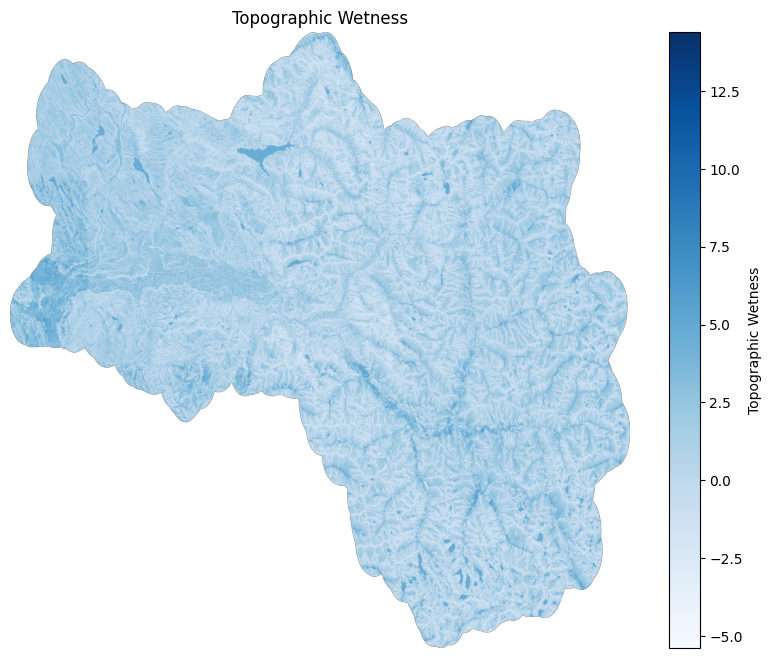

In [12]:
filled_dem_rd = rd.rdarray(filled_dem, no_data=-9999)

# Compute slope and flow accumulation
# NOTE: Slope is rederived here!
degrees_slope = rd.TerrainAttribute(filled_dem_rd, attrib="slope_radians")
accum_d8 = rd.FlowAccumulation(filled_dem_rd, method="D8")

# Compute Topographic Wetness Index (TWI)
twi = np.log(accum_d8 / (np.tan(degrees_slope) + 0.01)).astype(
    np.float32
)  # Convert TWI to float32

# Save TWI to GeoTIFF
output_file = f"{output_dir}/TWI.tif"
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=twi.shape[0],
    width=twi.shape[1],
    count=1,
    dtype=str(twi.dtype),
    crs=CRS,
    transform=dem.geobox.affine,
    nodata=-9999,
) as dst:
    dst.write(twi, 1)

print(f"TWI GeoTIFF saved as {output_file}")

# Plotting TWI
plt.figure(figsize=(10, 8))
plt.imshow(twi, cmap="Blues", aspect="auto")
plt.colorbar(label="Topographic Wetness")
plt.title("Topographic Wetness")
plt.axis("off")
plt.show()

#### Depth to Water
The Depth-to-Water (DTW) index is a soil wetness indicator derived from a Digital Elevation Model (DEM). It calculates the least elevation difference between surface flow channels and surrounding landscape areas. The key points are:

* Surface Flow Channels as Reference: The DTW index considers surface flow channels, extracted from DEMs, as reference points representing the groundwater level.
* Calculation of DTW Values: DTW values are defined as zero at these surface flow channels. As you move away from these channels, the DTW values increase, reflecting greater depth to the water table and reduced soil wetness.
* Soil Wetness Indicator: A higher DTW value indicates that the area is further from surface water, suggesting lower soil moisture and drier conditions. Conversely, areas closer to surface water channels will have lower DTW values, indicating higher soil moisture.



The function calculates the DTW Index, which estimates the depth of surface water in meters based on the topographic characteristics of the terrain and the cost function for least-cost path calculation.
1. Calculates the threshold (t) for the minimal flow initiation area (FIA) based on the input parameter fia. The threshold represents how much area needs to accumulate downward the slope to result in a channel with simulated surface water. This step is necessary to determine which areas are likely to have surface water.
    * 0.25: This means that for water to start flowing, it needs to accumulate in an area of at least 0.25 hectares (2500 square meters).
    * 1: In this case, water needs to accumulate in an area of at least 1 hectare (10,000 square meters) to start flowing.
    * 4: Here, the required minimum area for water accumulation is 4 hectares (40,000 square meters).

2. Uses the calculated threshold to compare the flow accumulationto identify channels with surface water and sets them to 1 in the flowLines raster. Cells with flow accumulation below the threshold are marked as null. This step creates a binary raster layer where 1 represents channels with surface water, and null represents other areas.

3. Calculates the least-cost path of slope (cost) starting from the identified flow lines. This step helps determine the least costly path from each cell to the flow lines, considering the slope of the terrain. The cost raster will contain values representing the minimum height difference between each cell and the flow path.

4. Computes the Cartographic Depth-to-Water (DTW) Index in meters. The DTW raster is calculated by multiplying the cost raster by the spatial resolution of the DEM and dividing it by 100. This step converts the cost values (originally in percent) to represent the estimated depth of water in meters for each cell in the study area.


**References**
* [Using the Cartographic Depth-to-Water Index to Locate Small Streams and Associated Wet Areas across Landscapes](https://www.tandfonline.com/doi/full/10.4296/cwrj2011-909)
* [Evaluating the effect of DEM resolution on performance of cartographic depth-to-water maps, for planning logging operations](https://www.sciencedirect.com/science/article/pii/S030324342200054X)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


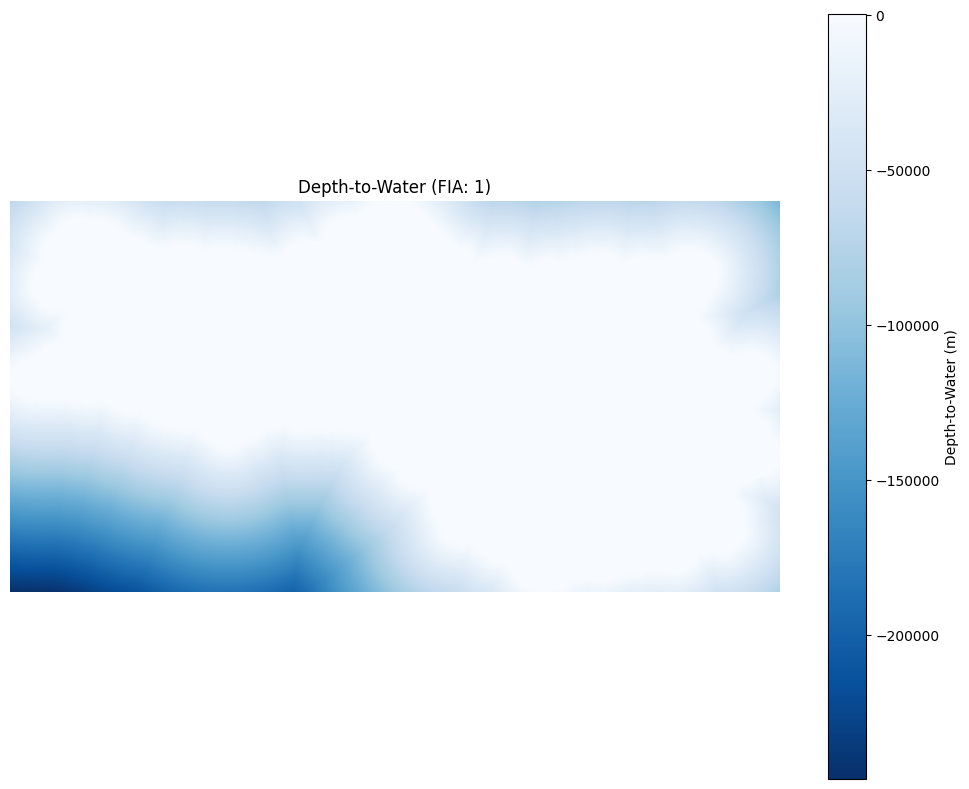

In [13]:
# Set the FIA value you want to use
fia = 1


def calcDTW(fia, filled_dem, percent_slope):
    # Step 1: Calculate the threshold for minimal flow initiation (t)
    resolution = filled_dem.rio.resolution()
    t = (
        fia * 10000 / (abs(resolution[0]) * abs(resolution[1]))
    )  # Convert FIA from hectares to square meters

    # Step 2: Calculate flow accumulation and identify flow lines/channels
    filled_dem_rd = rd.rdarray(filled_dem, no_data=-9999)
    accum_d8 = rd.FlowAccumulation(filled_dem_rd, method="D8")
    # Create binary flow channels
    flow_lines = accum_d8 >= t

    # Step 3: Calculate the least-cost of slope in percentage starting from the flow line
    cost_distance = distance_transform_edt(
        ~flow_lines
    )  # Use ~ to invert the binary mask

    # Step 4: Compute DTW in meters
    # Jesse: I _think_ percent slope is wanted here based on the comment below
    DTW = cost_distance * (percent_slope / 100)  # slope is already in percentage

    return DTW


# Calculate and plot DTW for FIA value 1
dtw = calcDTW(fia, filled_dem, percent_slope)
dtw_xr = xr.zeros_like(filled_dem)
dtw_xr.values = dtw

# Save the DTW result to a GeoTIFF file
output_file = f"{output_dir}/DTW.tif"
write_cog(dtw_xr, fname=output_file, overwrite=True)

# Plot DTW
plt.figure(figsize=(10, 8))
im = plt.imshow(dtw, cmap="Blues_r")
plt.colorbar(label="Depth-to-Water (m)")
plt.title(f"Depth-to-Water (FIA: {fia})")
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# Convert Mpho's original window sizes for 30-m dem to
# their equivalent in our DEM's resolution
nominal_resolution = abs(np.prod(dem.rio.resolution())) ** 0.5
window_sizes_30m = [(3, 3), (9, 9), (15, 15)]
window_sizes_m = [(90, 90), (270, 270), (450, 450)]


def nearest_larger_odd(n):
    return n if n % 1 == 0 else n + 1


window_sizes_cells = [
    (
        nearest_larger_odd(round(a / nominal_resolution)),
        nearest_larger_odd(round(b / nominal_resolution)),
    )
    for a, b in window_sizes_m
]
window_sizes_cells

[(9, 9), (27, 27), (45, 45)]

In [15]:
def create_kernel(w, method):
    kx, ky = w
    kernel = np.zeros((ky, kx))
    jy, jx = ky // 2, kx // 2  # Center of the kernel

    if method == "queen":
        kernel[:, :] = 1
    elif method == "rook":
        kernel[jy, :] = 1  # Horizontal
        kernel[:, jx] = 1  # Vertical
    elif method == "bishop":
        np.fill_diagonal(kernel, 1)
        np.fill_diagonal(np.fliplr(kernel), 1)
    elif method == "circle":
        y, x = np.ogrid[-jy : jy + 1, -jx : jx + 1]
        mask = x**2 + y**2 <= (kx // 2) ** 2
        kernel[mask] = 1
    elif method == "annulus":
        y, x = np.ogrid[-jy : jy + 1, -jx : jx + 1]
        outer_mask = x**2 + y**2 <= (kx // 2) ** 2
        inner_mask = x**2 + y**2 < ((kx // 2) - 1) ** 2
        kernel[outer_mask] = 1
        kernel[inner_mask] = 0

    return kernel

In [16]:
def terrain_indices(filled_dem, w=(3, 3), unit="degrees", method="queen"):
    if min(w) < 3:
        raise ValueError("Window size must be at least 3x3")
    if w[0] % 2 == 0 or w[1] % 2 == 0:
        raise ValueError("Window size must be odd")

    kernel = create_kernel(w, method)

    def focal_mean(arr, kernel):
        kernel = kernel / kernel.sum()
        return ndimage.convolve(arr, kernel, mode="constant", cval=np.nan)

    start_time = time.time()
    smoothed_dem = focal_mean(filled_dem, kernel)
    dz_dx, dz_dy = np.gradient(smoothed_dem)
    slope_k = np.arctan(np.hypot(dz_dx, dz_dy))
    if unit == "degrees":
        slope_k = np.degrees(slope_k)

    aspect_k = (-np.pi / 2) - np.arctan2(dz_dy, dz_dx)
    aspect_k = np.where(aspect_k < 0, aspect_k + 2 * np.pi, aspect_k)
    if unit == "degrees":
        aspect_k = np.degrees(aspect_k)

    dz2_dx2 = focal_mean(dz_dx, kernel) - dz_dx
    dz2_dy2 = focal_mean(dz_dy, kernel) - dz_dy
    dz2_dxdy = focal_mean(dz_dx, kernel) - focal_mean(dz_dy, kernel)

    curvature_k = dz2_dx2 + dz2_dy2
    profile_curvature_k = (
        dz2_dy2 * np.cos(aspect_k) ** 2
        + dz2_dx2 * np.sin(aspect_k) ** 2
        + 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    )
    planform_curvature_k = (
        dz2_dy2 * np.sin(aspect_k) ** 2
        + dz2_dx2 * np.cos(aspect_k) ** 2
        - 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    )

    focal_mean_tpi = focal_mean(smoothed_dem, kernel)
    tpi_k = smoothed_dem - focal_mean_tpi

    result = {
        "Slope": slope_k,
        "Curvature": curvature_k,
        "Profile_curvature": profile_curvature_k,
        "Planform_curvature": planform_curvature_k,
        "TPI": tpi_k,
    }

    print(f"Terrain indices computed in {time.time() - start_time:.2f} seconds")
    return result


def array_to_dataarray(array, filled_dem, metric):
    return xr.DataArray(
        array,
        dims=["y", "x"],
        coords={"y": filled_dem.coords["y"], "x": filled_dem.coords["x"]},
        attrs={
            "crs": filled_dem.attrs["crs"],
            "nodata": filled_dem.attrs.get("nodata", None),
        },
    ).rename(metric)


data = {}

for w in window_sizes_cells:
    print(f"Processing window size: {w}")
    results = terrain_indices(filled_dem, w=w)
    for metric, result in results.items():
        if metric not in data:
            data[metric] = {}
        data[metric][w] = result
        result_da = array_to_dataarray(result, filled_dem, metric)
        write_cog(
            result_da,
            fname=f"{output_dir}/{metric}_{nominal_resolution * w[0]}m.tif",
            overwrite=True,
        )
    print(f"All indices for {w} saved to {output_dir}")

Processing window size: (9, 9)
Terrain indices computed in 11.51 seconds
All indices for (9, 9) saved to /data/terrain_attributes
Processing window size: (27, 27)
Terrain indices computed in 87.85 seconds
All indices for (27, 27) saved to /data/terrain_attributes
Processing window size: (45, 45)
Terrain indices computed in 244.93 seconds
All indices for (45, 45) saved to /data/terrain_attributes


#### Plot multi-scale terrain indices

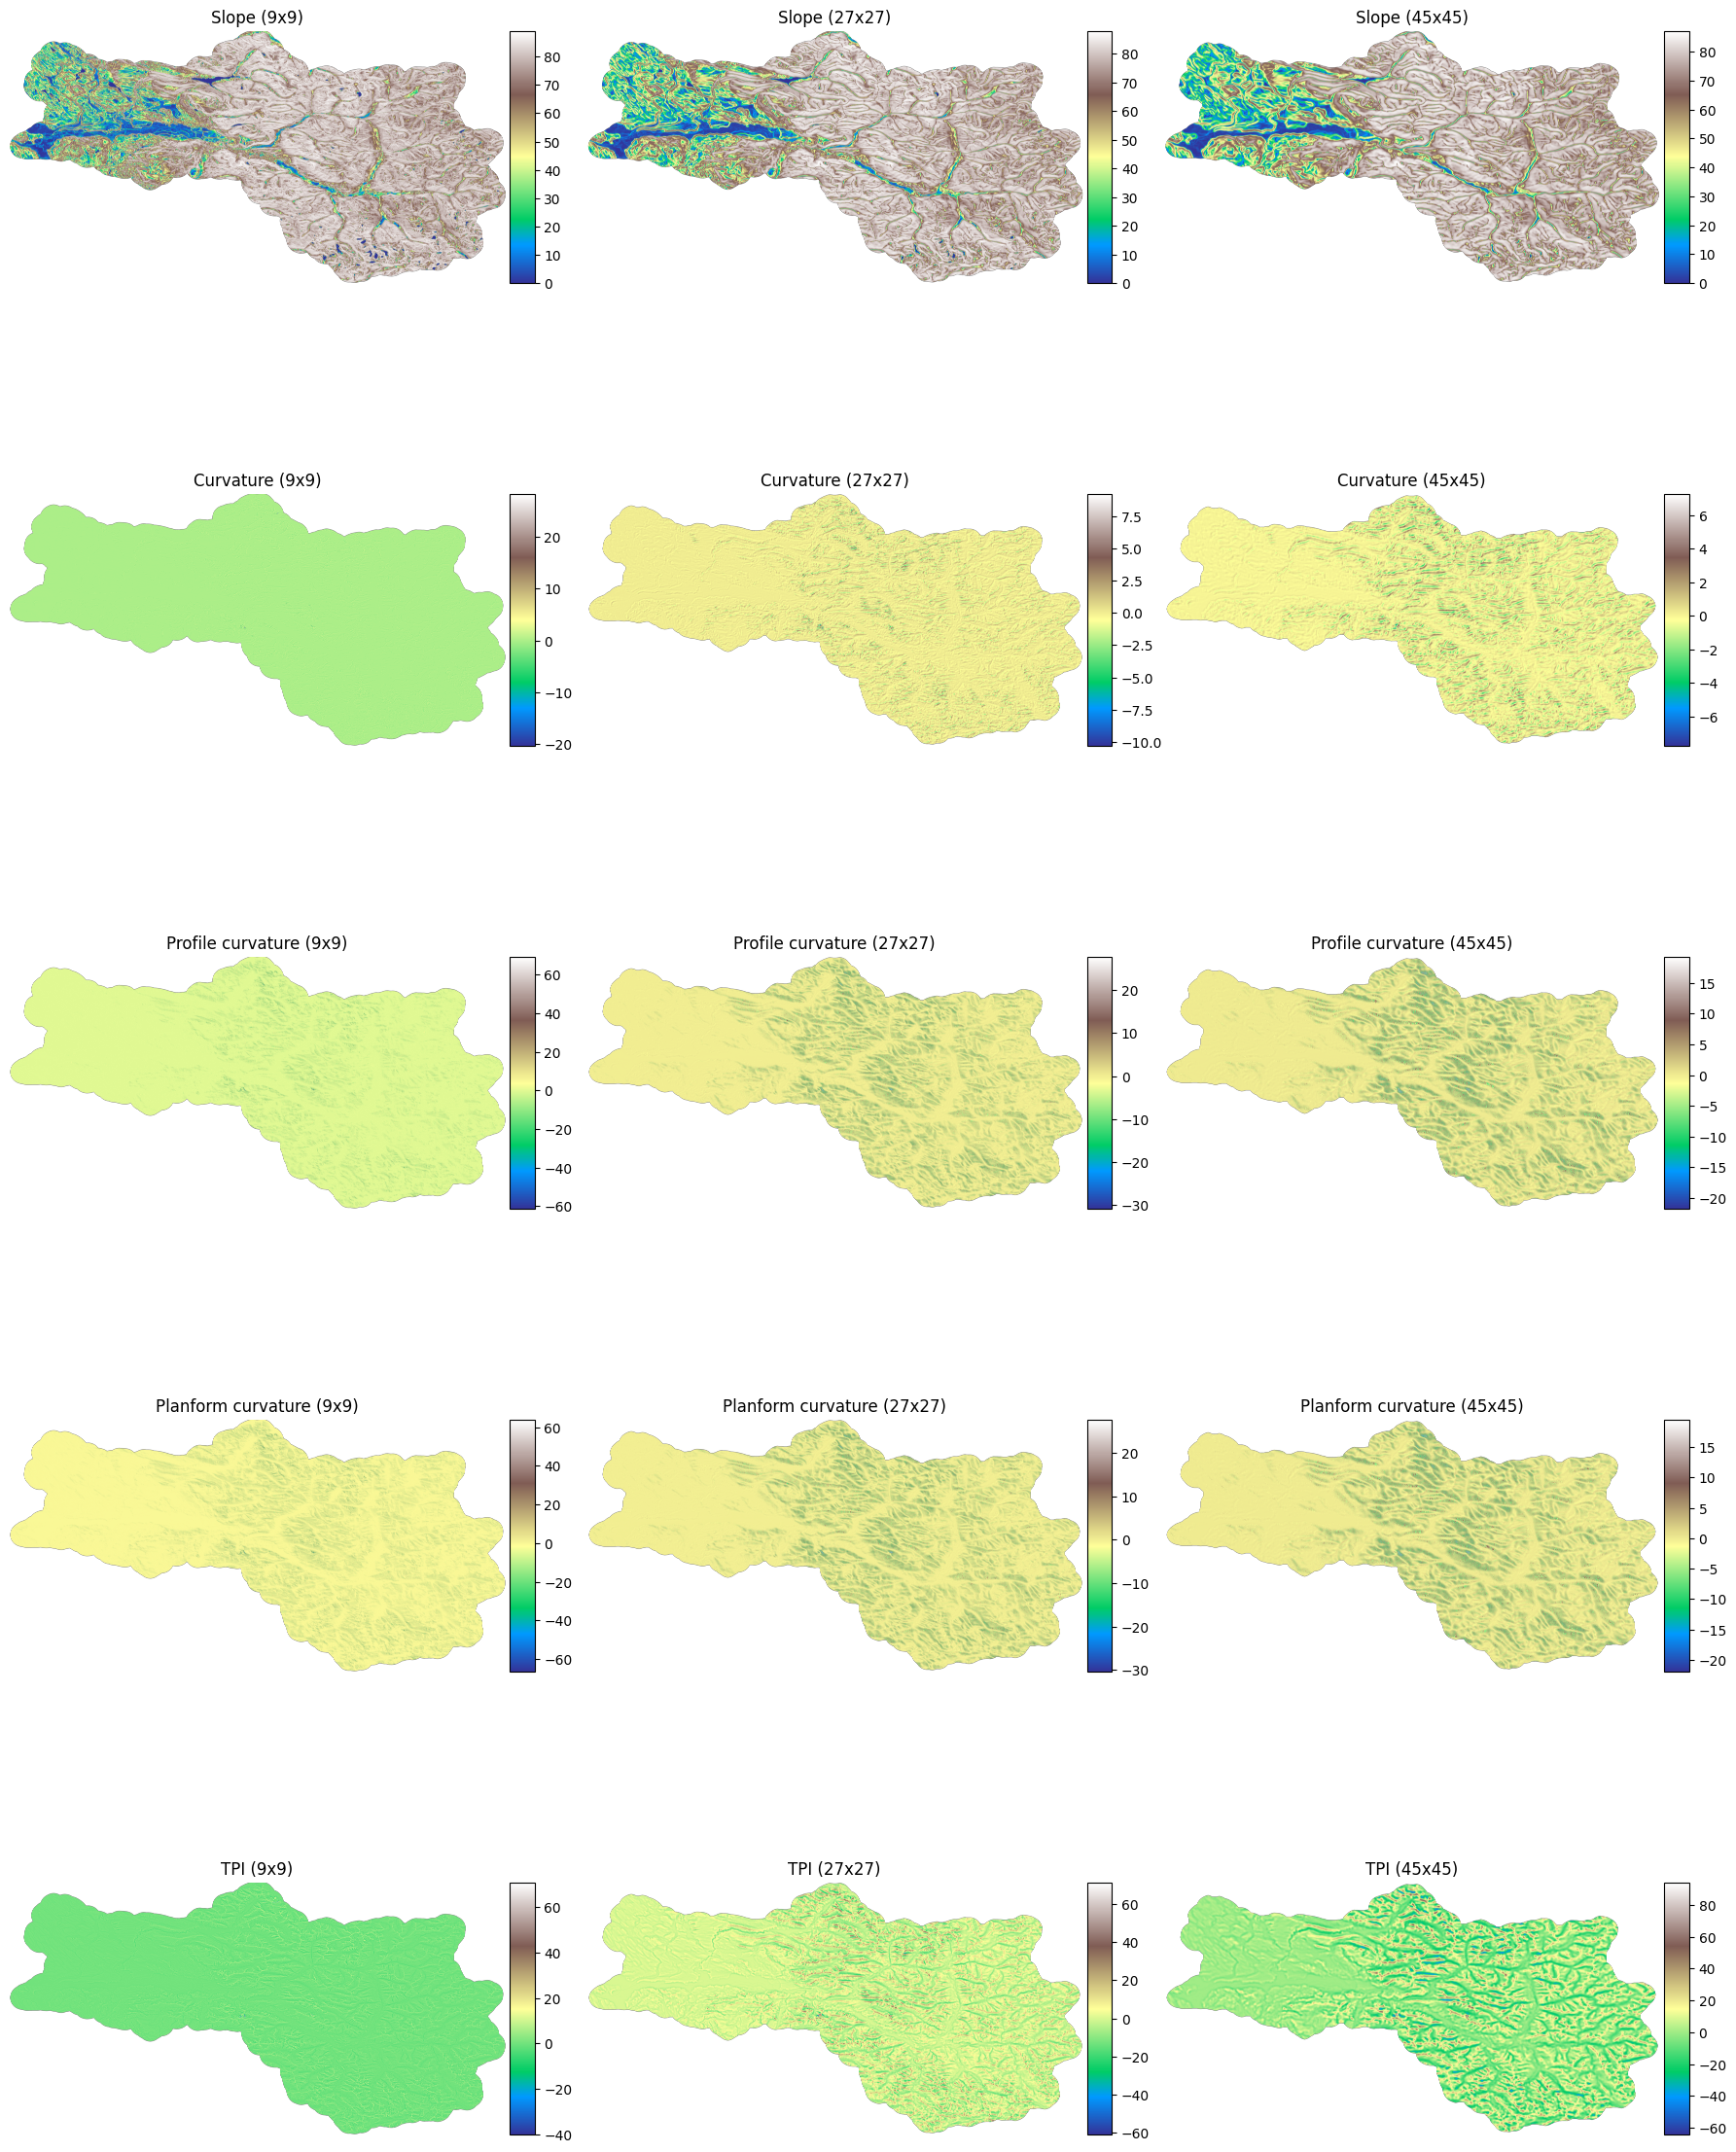

In [17]:
fig, axes = plt.subplots(
    len(data), len(window_sizes_cells), figsize=(18, 5 * len(data))
)

# Ensure axes is always a 2D array
if len(data) == 1:
    axes = np.expand_dims(axes, axis=0)
if len(window_sizes_cells) == 1:
    axes = np.expand_dims(axes, axis=1)

for i, (metric, windows_data) in enumerate(data.items()):
    for j, w in enumerate(window_sizes_cells):
        ax = axes[i, j]
        im = ax.imshow(windows_data[w], cmap="terrain", origin="upper")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.set_title(f"{metric} ({w[0]}x{w[1]})".replace("_", " "))
        ax.axis("off")
plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [18]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2025-07-09'